In [1]:
!pip install --upgrade tensorflow --user
!pip install tf-quant-finance
!pip install QuantLib-Python

In [2]:
import os
# reduce number of threads
os.environ['TF_NUM_INTEROP_THREADS'] = '1'
os.environ['TF_NUM_INTRAOP_THREADS'] = '1'

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tf_quant_finance as tff 
import tensorflow as tf
import functools
import pandas as pd
import time
import QuantLib as ql

In [3]:
#@title Set up parameters

dtype = tf.float64 #@param
num_samples = 200000 #@param
num_timesteps = 100#100 #@param
nb_options = 3

# expiries =tf.constant( [0.0, 0.5, 1.0], dtype=dtype) # This can be a rank 1 Tensor
dt = 1. / num_timesteps
# times = [1.0]
times = tf.linspace(tf.constant(0.0, dtype=dtype), tf.constant(1.0, dtype=dtype), num_timesteps)
rate = tf.constant(0.03, dtype=dtype)
sigma = tf.constant(0.1, dtype=dtype)
spot = tf.constant(700, dtype=dtype)
strikes = tf.linspace(0.5*spot, 1.5*spot, nb_options)

def set_up_pricer(times, watch_params=False):
    """Set up European option pricing function under Black-Scholes model.
    
    Args:
        expiries: List of expiries at which to to sample the trajectories.
        watch_params: A Python bool. When `True`, gradients of the price function wrt the inputs
          are computed more efficiently. 
    Returns:
     A callable that accepts a rank 1 tensor of strikes, and scalar values for 
     the spots and  volatility values. The callable outputs prices of
     the European call options on the grid `expiries x strikes`.
    """
    def price_eu_options(strikes, spot, sigma):
        # Define drift and volatility functions. 
        def drift_fn(t, x):
          del t, x
          return rate - 0.5 * sigma**2
        def vol_fn(t, x):
          del t, x
          return tf.reshape(sigma, [1, 1])
        # Use GenericItoProcess class to set up the Ito process
        process = tff.models.GenericItoProcess(
            dim=1,
            drift_fn=drift_fn,
            volatility_fn=vol_fn,
            dtype=dtype)
        log_spot = tf.math.log(tf.reduce_mean(spot))
        if watch_params:
            watch_params_list = [sigma]
        else:
            watch_params_list = None
        paths = process.sample_paths(
            times=times, num_samples=num_samples,
            initial_state=log_spot, 
            watch_params=watch_params_list,
            # Select a random number generator
            random_type=tff.math.random.RandomType.PSEUDO_ANTITHETIC,
            time_step=dt)
        prices = (tf.exp(-tf.expand_dims(rate * times, axis=-1))
                  * tf.reduce_mean(tf.nn.relu(tf.math.exp(paths) - strikes), 0))
        return prices
    return price_eu_options

price_eu_options = tf.function(set_up_pricer(times))
price_eu_options2 = tf.function(set_up_pricer(times))
# price_eu_options_xla = tf.function(set_up_pricer(times), jit_compile=True)
# price_eu_options = set_up_pricer(times)
# price_eu_options_xla = set_up_pricer(times)

In [4]:
#@title Monte Carlo sampling in QuantLib

def ql_price(strike):
    num_samples = 200000 #@param
    num_timesteps = 100#100 #@param
    expiry = 1.0

    calculation_date = ql.Date(1, 1, 2010)
    maturity_date = ql.Date(1, 1, 2011)
    day_count = ql.Thirty360()
    calendar = ql.NullCalendar()

    ql_strike_price = strike
    sigma_ql = 0.1
    ql_volatility = ql.SimpleQuote(sigma_ql)
    ql_risk_free_rate = 0.03
    option_type = ql.Option.Call

    ql.Settings.instance().evaluationDate = calculation_date
    payoff = ql.PlainVanillaPayoff(option_type, ql_strike_price)

    eu_exercise = ql.EuropeanExercise(maturity_date)
    european_option_ql = ql.VanillaOption(payoff, eu_exercise)

    flat_ts = ql.YieldTermStructureHandle(
        ql.FlatForward(calculation_date, ql_risk_free_rate, day_count)
    )
    flat_vol_ts = ql.BlackVolTermStructureHandle(
        ql.BlackConstantVol(calculation_date, calendar,
                            ql.QuoteHandle(ql_volatility), day_count)
    )

    spot_ql = 700
    spot_price = ql.SimpleQuote(spot_ql)
    spot_handle = ql.QuoteHandle(
        spot_price
    )
    bsm_process = ql.BlackScholesProcess(spot_handle,
                                          flat_ts,
                                          flat_vol_ts)

    # Compute the same price number_of_options times

    engine = ql.MCEuropeanEngine(bsm_process, "PseudoRandom",
                                 timeSteps=num_timesteps,
                                 requiredSamples=num_samples,
                                 seed=42)

    european_option_ql.setPricingEngine(engine)
    price_ql = european_option_ql.NPV()
    return price_ql

ql_prices = []
t = time.time()
for strike in strikes:
    price_ql = ql_price(strike.numpy())
    ql_prices.append(price_ql)
time_price_ql = time.time() - t
print(ql_prices)
print("Time (seconds) to price a European Call Option using QuantLib: ", time_price_ql, nb_options/time_price_ql)

[360.38096816219917, 39.038114908742635, 0.0017499648447671884]
Time (seconds) to price a European Call Option using QuantLib:  55.04422903060913 0.05450162628913837


In [5]:
#@title Pricing times on CPU and GPU platforms

time_start = time.time()
with tf.device("/cpu:0"):
    price_cpu_nograph = set_up_pricer(times)(strikes, spot, sigma)
time_end = time.time()
time_price_cpu_nograph = time_end - time_start
print(price_cpu_nograph[:10])

time_start = time.time()
with tf.device("/gpu:0"):
    set_up_pricer(times)(strikes, spot, sigma)
time_end = time.time()
time_price_gpu_nograph = time_end - time_start

# GPU without XLA
time_start = time.time()
with tf.device("/gpu:0"):
    price_eu_options(strikes, spot, sigma)
time_end = time.time()
time_price_gpu0 = time_end - time_start
# Second run (excludes graph optimization time)
time_start = time.time()
with tf.device("/gpu:0"):
    prices = price_eu_options(strikes, spot, sigma)
time_end = time.time()
time_price_gpu = time_end - time_start

# CPU without XLA
time_start = time.time()
with tf.device("/cpu:0"):
    price_eu_options(strikes, spot, sigma)
time_end = time.time()
time_price_cpu0 = time_end - time_start    
time_start = time.time()
with tf.device("/cpu:0"):
    prices = price_eu_options(strikes, spot, sigma)
time_end = time.time()
time_price_cpu = time_end - time_start

print('time_price_cpu_nograph', time_price_cpu_nograph, nb_options/time_price_cpu_nograph)
print('time_price_gpu_nograph', time_price_gpu_nograph, nb_options/time_price_gpu_nograph)

print('time_price_gpu0', time_price_gpu0, nb_options/time_price_gpu0)
print('time_price_gpu', time_price_gpu, nb_options/time_price_gpu)

print('time_price_cpu0', time_price_cpu0, nb_options/time_price_cpu0)
print('time_price_cpu', time_price_cpu, nb_options/time_price_cpu)


tf.Tensor(
[[350.           0.           0.        ]
 [350.1060924    2.91129653   0.        ]
 [350.21199042   4.18344954   0.        ]
 [350.31776297   5.17319482   0.        ]
 [350.42367442   6.02846904   0.        ]
 [350.52985658   6.81533993   0.        ]
 [350.63537854   7.5161541    0.        ]
 [350.74158166   8.17492942   0.        ]
 [350.84768899   8.80843832   0.        ]
 [350.95208814   9.3809389    0.        ]], shape=(10, 3), dtype=float64)
time_price_cpu_nograph 7.937425136566162 0.3779563206435281
time_price_gpu_nograph 2.2704100608825684 1.321347210218854
time_price_gpu0 5.036483287811279 0.5956537187883174
time_price_gpu 1.2024767398834229 2.494850753030651
time_price_cpu0 6.686890602111816 0.4486390130343327
time_price_cpu 6.541736125946045 0.4585938567747028


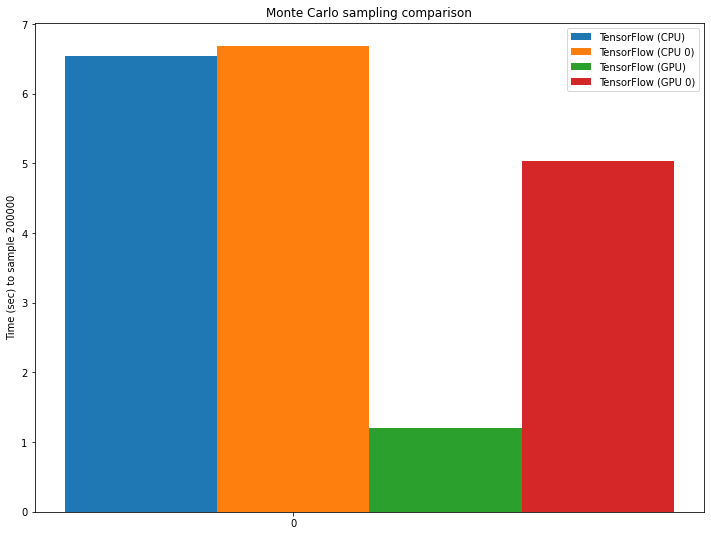

In [6]:
#@title Plot the results

ind = np.arange(1)  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots()

fig.set_figheight(9)
fig.set_figwidth(12)

ax.bar(ind - width/8, [time_price_cpu], width / 8,
       label='TensorFlow (CPU)')
ax.bar(ind, [time_price_cpu0], width / 8,
       label='TensorFlow (CPU 0)')
ax.bar(ind + width/8, [time_price_gpu], width / 8,
       label='TensorFlow (GPU)')
ax.bar(ind + width/4, [time_price_gpu0], width / 8,
       label='TensorFlow (GPU 0)')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Time (sec) to sample {}'.format(num_samples))
ax.set_title('Monte Carlo sampling comparison')
ax.set_xticks(ind)
ax.legend()


plt.show()